<hr>
<h1> Predicting Water Potability <h1>
<hr>
<h5> By : Malick Tobe, Angeline Teo, Alexander Naishuler <h5>


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import xgboost as xgb
import random 


import sklearn

from sklearn import metrics

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, r2_score, mean_squared_error

from sklearn.model_selection import train_test_split, KFold, cross_val_score, train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB

<h2> I - Exploratory Data Analysis <h2>

In [2]:
# Reading the Data and Performing Basic Data Checks
df = pd.read_csv('water_potability.csv')

# replace null values based on the group/sample mean
df['ph']=df['ph'].fillna(df.groupby(['Potability'])['ph'].transform('mean'))
df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

df = df.dropna()
print(df.shape)
df.describe().transpose()

(3276, 10)


,count,mean,std,min,25%,50%,75%,max
ph,3276.0,7.080855,1.469958,0.000000,6.277673,7.085378,7.870050,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,3276.0,333.785123,36.145701,129.000000,317.094638,334.564290,350.385756,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3276.0,66.395671,15.769901,0.738000,56.647656,66.303555,76.666609,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


# Generate Visualizations

df_seaborn =   df[['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon',
          'Trihalomethanes','Turbidity',"Potability"]]
sns.set_theme(style="ticks")
sns.pairplot(df_seaborn, hue="Potability")
plt.show()

<AxesSubplot:>

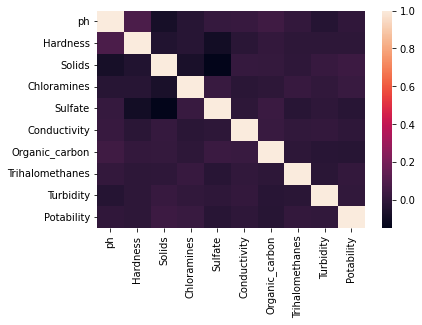

In [3]:
sns.heatmap(df.corr())

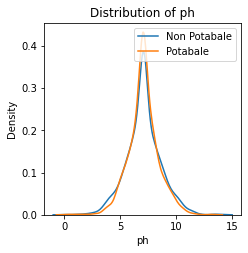

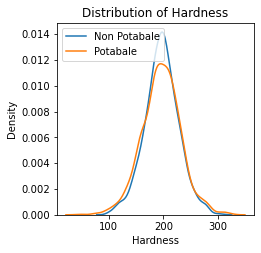

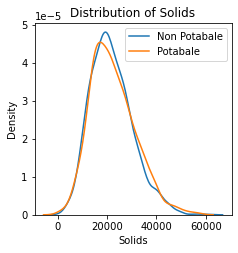

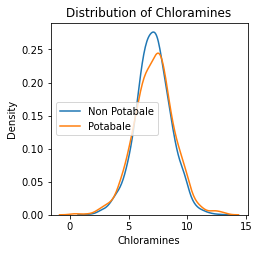

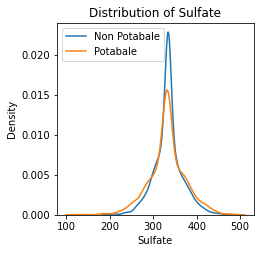

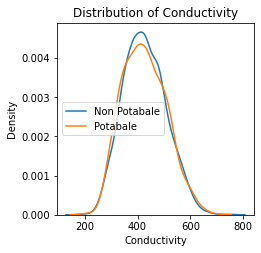

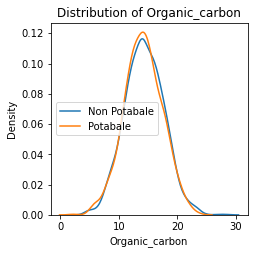

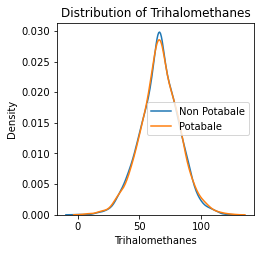

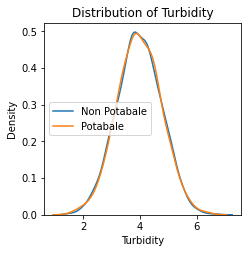

In [4]:
non_potabale = df.query('Potability == 0')
potabale     = df.query('Potability == 1')

for ax,col in enumerate(df.columns[:9]):
    plt.figure(figsize=(12,12))
    plt.subplot(3,3,ax+1)
    plt.title(f'Distribution of {col}')
    sns.kdeplot(x=non_potabale[col],label='Non Potabale')
    sns.kdeplot(x=potabale[col],label='Potabale')
    plt.legend(prop=dict(size=10))

<h2> II - Multilayer Perceptron <h2>

In [5]:
# Creating Arrays for the Features and the Response Variable

target_column = ['Potability'] 
predictors = list(set(list(df.columns))-set(target_column))
df[predictors] = df[predictors]/df[predictors].max()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ph,3276.0,0.505775,0.104997,0.000000,0.448405,0.506098,0.562146,1.0
Hardness,3276.0,0.607722,0.101756,0.146792,0.547315,0.609573,0.670540,1.0
Solids,3276.0,0.359548,0.143214,0.005242,0.255878,0.341806,0.446415,1.0
Chloramines,3276.0,0.542567,0.120598,0.026815,0.466780,0.543178,0.618183,1.0
Sulfate,3276.0,0.693896,0.075142,0.268174,0.659198,0.695516,0.728406,1.0
Conductivity,3276.0,0.565752,0.107287,0.240905,0.485482,0.560017,0.639539,1.0
Organic_carbon,3276.0,0.504769,0.116896,0.077739,0.426353,0.502415,0.585076,1.0
Trihalomethanes,3276.0,0.535449,0.127177,0.005952,0.456836,0.534706,0.618279,1.0
Turbidity,3276.0,0.588631,0.115801,0.215165,0.510419,0.586886,0.667802,1.0
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.0


In [6]:
# Creating the Training and Test Datasets

X = df[predictors].values
y = df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)
print(X_train.shape); print(X_test.shape)

(2293, 9)
(983, 9)


In [7]:
# Building, Predicting, and Evaluating the Neural Network Model

mlp = MLPClassifier(max_iter=500)#hidden_layer_sizes=(9,9,9), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train.ravel())

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [8]:
print('Train Data')
#print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

Train Data
              precision    recall  f1-score   support

           0       0.68      0.93      0.79      1416
           1       0.73      0.30      0.43       877

    accuracy                           0.69      2293
   macro avg       0.70      0.62      0.61      2293
weighted avg       0.70      0.69      0.65      2293



In [9]:
#print(confusion_matrix(y_test,predict_test))
print('Test Data')
print(classification_report(y_test,predict_test))

Test Data
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       582
           1       0.71      0.27      0.39       401

    accuracy                           0.66       983
   macro avg       0.68      0.60      0.58       983
weighted avg       0.67      0.66      0.61       983



In [10]:
# Define the number of folds for cross-validation
n_folds = 10

# Initialize the cross-validation method
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform cross-validation
for train_idx, test_idx in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Fit the MLP model on the training set
    mlp.fit(X_train, y_train.ravel())
    
    # Predict the labels for the testing set
    y_pred = mlp.predict(X_test)
    

# Print the overall classification report and confusion matrix
print("Test Data After 10-fold cross-validation")
print(classification_report(y, mlp.predict(X)))
#print("Confusion Matrix:")
#print(confusion_matrix(y, mlp.predict(X)))

Test Data After 10-fold cross-validation
              precision    recall  f1-score   support

           0       0.68      0.92      0.78      1998
           1       0.72      0.33      0.45      1278

    accuracy                           0.69      3276
   macro avg       0.70      0.62      0.62      3276
weighted avg       0.70      0.69      0.65      3276



<h2> III - Decision Tree Classifier and Random Forest <h2>

In [11]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [12]:
# Hyperparameter Tuning using GridSearchCV, 5-fold CV
%%time
dt_clf = DecisionTreeClassifier()
dt_params = [{'criterion': ['entropy', 'gini'],
              'max_depth': [item if item!=0 else 1 for item in range(0, 51, 5)],
              'min_samples_split': np.arange(2, 20), 
              'min_samples_leaf': np.arange(1, 10)}]

gs_dt = GridSearchCV(dt_clf, dt_params, cv=5, scoring='roc_auc')
gs_dt.fit(X_train, y_train)

CPU times: user 3min 11s, sys: 549 ms, total: 3min 12s
Wall time: 3min 10s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45,
                                        50],
                          'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])}],
             scoring='roc_auc')

In [13]:
gs_dt_preds = gs_dt.predict(X_test)

print(gs_dt.best_params_)    
print(classification_report(y_test, gs_dt_preds))

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 18}
              precision    recall  f1-score   support

           0       0.72      0.91      0.81       585
           1       0.79      0.49      0.60       398

    accuracy                           0.74       983
   macro avg       0.76      0.70      0.70       983
weighted avg       0.75      0.74      0.72       983



<h5> XGBoost <h5> 

In [14]:
%%time
xgb_clf = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

xgb_params = [{
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}]

gs_xgb = GridSearchCV(xgb_clf, xgb_params, cv=5, scoring='roc_auc')
gs_xgb.fit(X_train, y_train)

CPU times: user 8min 27s, sys: 1min 15s, total: 9min 42s
Wall time: 1min 19s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=Non

In [15]:
print(gs_xgb.best_params_) 

gs_xgb_preds = gs_xgb.predict(X_test)

print(classification_report(y_test, gs_xgb_preds))

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 140}
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       585
           1       0.82      0.60      0.69       398

    accuracy                           0.78       983
   macro avg       0.79      0.75      0.76       983
weighted avg       0.79      0.78      0.78       983



<h5> Random Forest <h5>

In [16]:
%%time
rf_clf = RandomForestClassifier()
rf_params = [{
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}]

gs_rf = GridSearchCV(estimator = rf_clf, param_grid = rf_params,
                     cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=   3.6s

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   3.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sampl

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sampl

CPU times: user 4.54 s, sys: 596 ms, total: 5.14 s
Wall time: 4min 52s


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                          'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                          'min_samples_split': [8, 10, 12],
                          'n_estimators': [100, 200, 300, 1000]}],
             scoring='roc_auc', verbose=2)

In [17]:
print(gs_rf.best_params_) 

gs_rf_preds = gs_rf.predict(X_test)

print(classification_report(y_test, gs_rf_preds))

{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       585
           1       0.84      0.61      0.70       398

    accuracy                           0.79       983
   macro avg       0.81      0.76      0.77       983
weighted avg       0.80      0.79      0.79       983



<h2> IV - Naive Bayes Classifier <h2>

In [18]:
# get feature values
X = df.drop(['Potability'], axis=1)
# get class values
y = df['Potability']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 300)

# initialize the model
NBclassifier = GaussianNB()

# train the model
NBmodel = NBclassifier.fit(X_train, y_train)

# make predictions 
NBpreds = NBclassifier.predict(X_test)
NBpreds_train = NBclassifier.predict(X_train)

print("\nTrain Classification Report :")
print(classification_report(y_train, NBpreds_train))


Train Classification Report :
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      1401
           1       0.57      0.25      0.35       892

    accuracy                           0.64      2293
   macro avg       0.61      0.57      0.55      2293
weighted avg       0.62      0.64      0.59      2293



In [19]:
print("\nTest Classification Report :")
print(classification_report(y_test, NBpreds))


Test Classification Report :
              precision    recall  f1-score   support

           0       0.63      0.86      0.73       597
           1       0.52      0.24      0.32       386

    accuracy                           0.61       983
   macro avg       0.58      0.55      0.53       983
weighted avg       0.59      0.61      0.57       983



<h5> # Hyperparameter Tuning using GridSearchCV, 5-fold CV <h5>

In [20]:
params = {'var_smoothing': [1e-9, 1e-6, 1e-12]}

gaussian_nb_grid = GridSearchCV(GaussianNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
gaussian_nb_grid.fit(X_train,y_train)

print('Best Accuracy Through Grid Search : {:.3f}'.format(gaussian_nb_grid.best_score_))
print('Best Parameters : {}\n'.format(gaussian_nb_grid.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Accuracy Through Grid Search : 0.631
Best Parameters : {'var_smoothing': 1e-09}



In [21]:
y_preds = gaussian_nb_grid.best_estimator_.predict(X_test)
y_preds_train = gaussian_nb_grid.best_estimator_.predict(X_train)

In [22]:
print("\nTest Classification Report after Cross Validation :")
print(classification_report(y_test, y_preds))


Test Classification Report after Cross Validation :
              precision    recall  f1-score   support

           0       0.63      0.86      0.73       597
           1       0.52      0.24      0.32       386

    accuracy                           0.61       983
   macro avg       0.58      0.55      0.53       983
weighted avg       0.59      0.61      0.57       983

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   3.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_sample

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   3.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=   3.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000; total time=   3.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=   3.8s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sam

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=   3.6s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   3.5s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000; total time=   3.5s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000; total time=   3.5s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000; total time=   3.5s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sampl